In [1]:
# Standard Librarys
import pandas as pd
import numpy as np

# Data Visualization Librarys
import matplotlib.pyplot as plt
import seaborn as sns
import calmap
import squarify

# Stats library
import scipy.stats as sct

# defining data paths
path_dados_clientes = 'dados/dados_clientes.csv'
path_eventos_ofertas = 'dados/eventos_ofertas.csv'
path_portfolio_ofertas = 'dados/portfolio_ofertas.csv'

# Dicionario de cores
primary_blue = "#496595"
primary_grey = "#c6ccd8"

In [2]:
## Analisando dados dos clientes
data_clientes = pd.read_csv(path_dados_clientes)
data_clientes.head(3)

,Unnamed: 0,genero,idade,id,membro_desde,renda_anual
0,1,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,2,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,3,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN


In [3]:
data_clientes.dtypes

Unnamed: 0        int64
genero           object
idade             int64
id               object
membro_desde      int64
renda_anual     float64
dtype: object

In [4]:
print('temos um total de {} linhas, e {} colunas '.format(data_clientes.shape[0], data_clientes.shape[1]))

temos um total de 17000 linhas, e 6 colunas 


In [5]:
porcentagem_nulos = (data_clientes.isnull().sum() / data_clientes.shape[0])*100
porcentagem_nulos

Unnamed: 0       0.000000
genero          12.794118
idade            0.000000
id               0.000000
membro_desde     0.000000
renda_anual     12.794118
dtype: float64

In [6]:
data_clientes.genero.value_counts(normalize=True)*100

M    57.227656
F    41.342327
O     1.430017
Name: genero, dtype: float64

In [7]:
idade_clientes = data_clientes[data_clientes['idade'] <= 100]['idade']
# pelo fato de a media ser um valor extremamente influenciavel por outliers e sempre recomendavel 
# removelos para analisar valores com mais 'precisao'
print(f' Idade Media antes de remover outliers: {round(data_clientes.idade.mean(), 2)}')
print(f' Idade Media Depois de remover outliers: {round(idade_clientes.mean(), 2)} ')

 Idade Media antes de remover outliers: 62.53
 Idade Media Depois de remover outliers: 54.38 


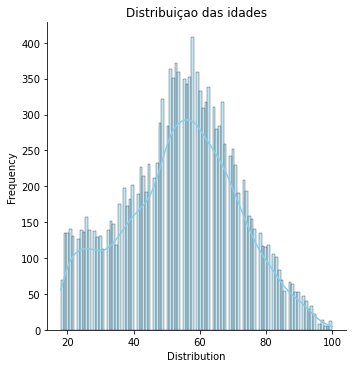

In [8]:
# Sem o filtro de idades descobri muitos clientes com 120 anos, certamente dados errados

ax = sns.displot(idade_clientes,
                  bins=100,
                  kde=True,
                  color='skyblue',
                  );

ax.set(title='Distribuiçao das idades');
ax.set(xlabel='Distribution', ylabel='Frequency');

In [9]:
def get_sample(df, col_name, n=100, seed=42):
    '''
    Funcao para auxiliar os testes de normalidade dos dados
    '''
    np.random.seed(seed)
    
    random_idx = np.random.choice(df[col_name].dropna().index, size=n, replace=False)
    
    return df.loc[random_idx, col_name]

sample = get_sample(data_clientes[data_clientes['idade'] <= 100], 'idade', n=5000)
print(bool(sct.shapiro(sample)[1] >= 0.05))
# a Idade nao segue uma distribuiçao normal

False


In [10]:
# Analisando a coluna de Data onde o cliente se tornou cliente
data_clientes['membro_desde'].sample(5)

14967    20140216
10483    20170223
6538     20170727
7684     20170808
11035    20160831
Name: membro_desde, dtype: int64

<p>Um pocuo de Feature Engeniering</p>

In [11]:
## Ajustando os formatos de datas
data_clientes['membro_desde'] = pd.to_datetime(data_clientes['membro_desde'], format='%Y%m%d')
## Criando variaveis de datas relacionadas a data da aquisiçao do cliente!
data_clientes['membro_desde_mes'] = data_clientes['membro_desde'].dt.month
data_clientes['membro_desde_dia'] = data_clientes['membro_desde'].dt.day

## Separando os clientes em grupos de idades para uma analise Macro
bin_labels_idades = ['17-26', '27-36', '37-45', '46-55', '56-63', '64-72' , '72+']
bins_cortes =       [17,27, 37, 46, 56, 64, 73, 90]

data_clientes['grupos_idades'] = pd.cut( data_clientes[data_clientes['idade'] <= 100]['idade'],
                                         bins=bins_cortes,  labels=bin_labels_idades)

## Criando uma nova coluna com a renda mensal de cada cliente para uma posterior analise
data_clientes['renda_mensal'] = round(data_clientes['renda_anual'] / 12, 0)
data_clientes['renda_mensal'] = data_clientes['renda_mensal'].fillna(0).astype(int)

## Separando os clientes por grupos de rendas mensais!
bin_grupos = ['classe E', 'classe D', 'classe C', 'classe B', 'classe A']
bins_cortes = [0, 1254, 2004, 8641, 11261]

data_clientes['grupos_renda'] = pd.cut( data_clientes['renda_mensal'],
                                        bins=bins_cortes,  labels=bin_grupos)

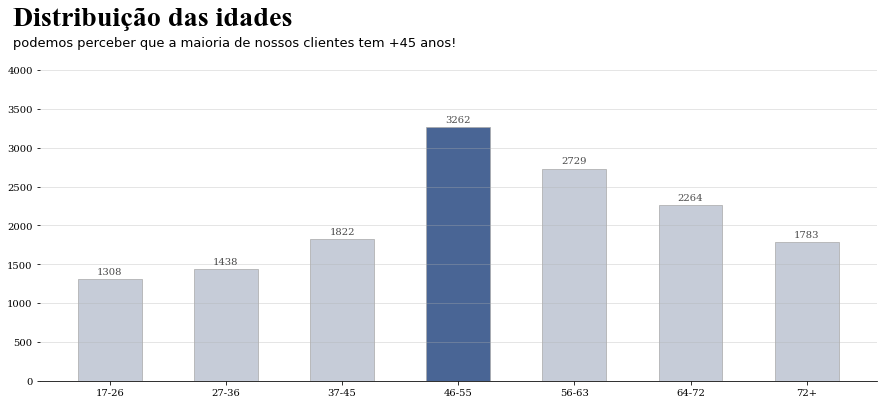

In [13]:
# Separando dados para a analise
data_ = data_clientes['grupos_idades'].value_counts().sort_index()

# Definindo dicionario de cores para dar foco ao grupo principal de idades
color_pall = [primary_grey for _ in range(6)]
color_pall[3] = primary_blue

fig, ax = plt.subplots(1,1, figsize=(15, 6))
ax.bar(
    data_.index,
    data_, width=0.55, 
    edgecolor='darkgray', color=color_pall,
    linewidth=0.7);

for i in data_.index:
    ax.annotate(f"{data_[i]}", 
                   xy=(i, data_[i] + 100),
                   va = 'center', ha='center',fontweight='light', fontfamily='serif',
                   color='#4a4a4a')


for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)

ax.set_ylim(0, 4200)    
ax.set_xticklabels(data_.index, fontfamily='serif')
ax.set_yticklabels(np.arange(0, 4001, 500),fontfamily='serif')

fig.text(0.1, 0.95, 'Distribuição das idades', fontsize=28, fontweight='bold', fontfamily='Times New Roman');
fig.text(0.1, 0.90, 'podemos perceber que a maioria de nossos clientes tem +45 anos!', fontsize=13,
         fontfamily="Helvetica", fontweight='100');

ax.grid(axis='y', linestyle='-', alpha=0.4)    
plt.show()

In [16]:
total_h = []
total_m = []
total_o = []

for i in range(0, 7):
    outros_p1 = data_genero_grupo_idades.value_counts().sort_index()[0:3].index.values[0][i]
    mulheres_p1 = data_genero_grupo_idades.value_counts().sort_index()[0:3].index.values[1][i]
    homens_p1 = data_genero_grupo_idades.value_counts().sort_index()[0:3].index.values[2][i]
    
    soma_total = (outros_p1 + mulheres_p1 + homens_p1)
    #print(soma_total)
    
    porcentagem_outros = (outros_p1 / soma_total)
    procentagem_mulheres = (mulheres_p1 / soma_total)
    porcentagem_homens = (homens_p1 / soma_total)
    
    total_h.append(porcentagem_homens)
    total_m.append(procentagem_mulheres)
    total_o.append(porcentagem_outros)
    
    #for i in range(1, 4, 1):
    # [1:2].index.values[0][0]
    
teste = pd.DataFrame([total_h, total_m, total_o]).T
teste.rename(columns={0:'Homens', 1:'Mulheres', 2:'Outro'},
             index={0:'17-26', 1:'27-36', 2:'37-45', 3:'45-55', 4:'55-63',
                    5:'64-72', 6:'72+'}, inplace=True)

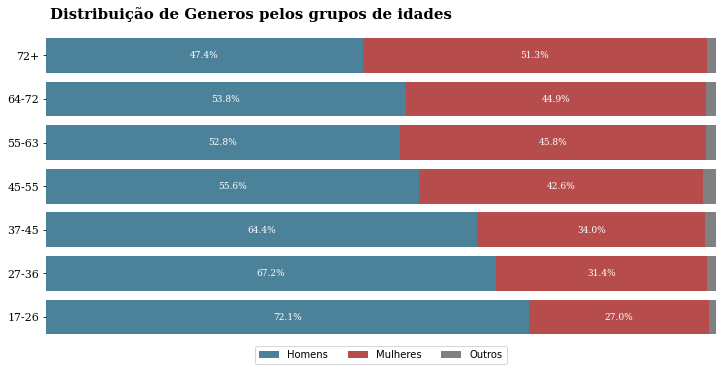

In [23]:
# Filtrando os dados para o plot
ordem_genero = data_clientes['genero'].dropna().value_counts().index
data_genero_grupo_idades = data_clientes[['grupos_idades', 'genero']].groupby('genero')['grupos_idades'].value_counts().unstack().loc[ordem_genero]
data_genero_grupo_idades.columns = data_genero_grupo_idades.columns.astype(str)
data_genero_grupo_idades['sum'] = data_genero_grupo_idades.sum(axis=1)
data_clientes_porcentagem = (data_genero_grupo_idades.T / data_genero_grupo_idades['sum']).T.rename(index={'M':'Homens', 'F':'Mulheres','O':'Outro'})
data_clientes_porcentagem_ = data_clientes_porcentagem.T[:-1]


fig, ax = plt.subplots(1,1,figsize=(12, 6),)
ax.barh(teste.index, teste['Homens'], 
        color='#004c70', alpha=0.7, label='Homens')

ax.barh(teste.index, teste['Mulheres'],
        left=teste['Homens'], 
        color='#990000', alpha=0.7, label='Mulheres')

ax.barh(teste.index, teste['Outro'], 
        left=teste['Homens'] + teste['Mulheres'], 
        color='#4a4a4a', alpha=0.7, label='Outros')

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticklabels(teste.index, fontfamily='serif', fontsize=11)

# Porcentagem de Homens
for i in teste.index:
    ax.annotate(f"{teste['Homens'][i]*100:.3}%", 
                   xy=(teste['Homens'][i]/2, i),
                   va = 'center', ha='center',fontsize=9, fontweight='light', fontfamily='serif',
                   color='white')

# Porcentagem de Mulheres
for i in teste.index:
    ax.annotate(f"{teste['Mulheres'][i]*100:.3}%", 
                   xy=(teste['Homens'][i]+teste['Mulheres'][i]/2, i),
                   va = 'center', ha='center',fontsize=9, fontweight='light', fontfamily='serif',
                   color='white')

# Porcentagem de Outros
#for i in teste.index:
#    ax.annotate(f"{teste['Outro'][i]*100:.3}%", 
#                   xy=(teste['Homens'][i]+teste['Mulheres'][i]
#                       +teste['Outro'][i]/2, i),
#                   va = 'center', ha='center',fontsize=9, fontweight='light', fontfamily='serif',
#                   color='white')
    

fig.text(0.130, 0.89, 'Distribuição de Generos pelos grupos de idades', fontsize=15, fontweight='bold', fontfamily='serif')   
#fig.text(0.131, 0.91, 'Pelo grafico, podemos perceber que a maioria dos clientes estao dividios entre Homens nas idades mais novas', fontsize=12,fontfamily='serif')   

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    
ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.06))
plt.show()

<p> O foco da gelateria e o grupo de classe <b>B+</b>, vamos analisar se a maioria dos nossos clientes sao desse grupo</p>

<p>Segundo a FGV essa tabela representa as classes economicas! </p>
<table>     
  <tr>
    <th>CLASSES ECONÔMICAS*</th> <th>LIMITE INFERIOR</th> <th>LIMITE SUPERIOR</th>
  </tr>
  <tbody>
     <tr>
         <td>Classe E </td>
         <td>0</td>
         <td>1.254</td>
      </tr>
      <tr>
        <td>Classe D</td>
        <td>1.255</td>
        <td>2.004</td>
      </tr>
      <tr>
        <td>Classe C</td>
        <td>2.005</td>
        <td>8.640</td>
      </tr>
      <tr>
        <td>Classe B </td>
        <td>8.641</td>
        <td>11.261</td>
      </tr>
      <tr>
        <td>Classe A</td>
        <td>11.262</td>
        <td>...</td>
      </tr>
</tbody>
</table>
<p>
    <sub><center>*Valores em Reais (R$)*</center></sub>
</p>

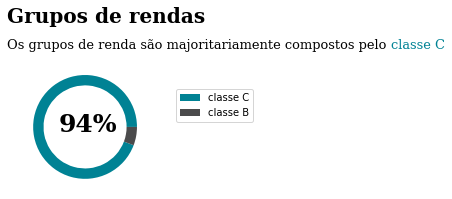

In [24]:
fig = plt.figure(figsize=(10,5)) # create figure
gs = fig.add_gridspec(2, 4)
gs.update(wspace=0.1, hspace=0)
ax0 = fig.add_subplot(gs[0:2, 0])

color_map = ["#008294", "#4b4b4c"]

ax0.pie(x=data_clientes['grupos_renda'].value_counts(), colors=color_map, wedgeprops=dict(width=0.2));

ax0.text(-1.5, 2, 'Grupos de rendas', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-1.5, 1.5, 'Os grupos de renda são majoritariamente compostos pela', 
         fontsize=13, fontweight='light', fontfamily='serif')
ax0.text(5.9, 1.5, 'classe C',fontsize=13,fontweight='light',fontfamily='serif', color=color_map[0])

ax0.text(-0.5, -0.1, '94%', 
         fontsize=25, fontweight='bold', fontfamily='serif')

#ax0.text(1.2, -0.5, '94%', 
#         fontsize=25, fontweight='bold', fontfamily='serif')

ax0.legend(data_clientes['grupos_renda'].value_counts()[0:2].index, loc="lower center", bbox_to_anchor=(1.5, 0.5));

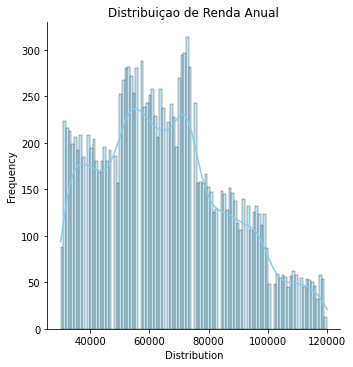

In [25]:
# Dividindo os clientes em grupos economicos
ax = sns.displot(data_clientes['renda_anual'],
                  bins=100,
                  kde=True,
                  color='skyblue',
                  );

ax.set(title='Distribuiçao de Renda Anual');
ax.set(xlabel='Distribution', ylabel='Frequency');

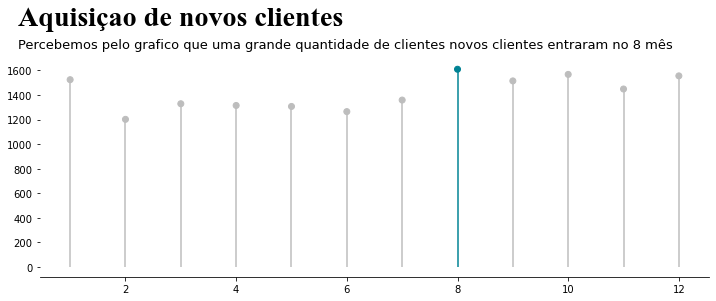

In [26]:
fig = plt.figure(figsize=(12,4)) # create figure
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])

color_map = ["#bdbdbd" for _ in range(12)]
color_map[7] = "#008294"

ax0.scatter(data_clientes['membro_desde_mes'].value_counts().sort_index().index,
         data_clientes['membro_desde_mes'].value_counts(ascending=False).sort_index(),
         color=color_map
            )

for i in range(0, 12, 1):
    ax0.vlines(x=data_clientes['membro_desde_mes'].value_counts().sort_index().index[i], 
           ymin=0, ymax=data_clientes['membro_desde_mes'].value_counts().sort_index().values[i],
          color=color_map[i])

#ax0.grid(color='black', linestyle=':', axis='x', zorder=0)

for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)

fig.text(0.1, 1, 'Aquisiçao de novos clientes', fontsize=28, fontweight='bold', fontfamily='Times New Roman')
fig.text(0.1, 0.92, 'Percebemos pelo grafico que uma grande quantidade de clientes novos clientes entraram no 8 mês', fontsize=13,
         fontfamily="Helvetica", fontweight='100');

<h3>Conclusao das analises da base de clientes:</h3>
<ul>
    <li>
        A maioria dos nossos clientes sao compostos por pessoas mais velhas, tendo um pico entre o publico +45
    </li>
    <li>
        Nossos grupos de idades mais novos tem mais homens, mas notamos uma inversao quando chegamos a grupos de idades maiores
    </li>
    <li>
        Apesar do foco da Paleteria ser nos grupos economicos B+, mais de 94% dos nossos clientes se encontram com uma renda de no maximo grupo C
    </li>
        <li>
        Analisar de maneira mais detalhada campanhas de marketing por datas podemos entender o porque nos messes 8, 12 e 1 tem um pico tao grande de novos clientes, (H0, alguma relaçao com o inverno)
    </li>
</ul>    